<a href="https://colab.research.google.com/github/martin-embryo/colab/blob/master/Training_split_wells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datetime import datetime
import sanity_tests

import numpy as np
import cv2
import sys
import csv
import os
import shutil
import glob
import h5py

from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import matplotlib
import hashlib

import argparse
from PIL import Image, ImageFilter, ImageEnhance

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from tensorflow.keras.utils import to_categorical, HDF5Matrix
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

from google.cloud import storage

project_id    = 'keen-incline-232408'
bucket_name   = 'embryonicsbucket'
model_dir  = 'Upload/Models'
data_dir   = 'Upload/Data'

storage_client = storage.Client(project = project_id)
bucket = storage_client.get_bucket(bucket_name)

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [2]:
#sanity checks
print(datetime.now())
sanity_tests.full()
print bucket.name

2019-05-08 05:56:28.943638
operating system is: Ubuntu 16.04
python version is 2.7.12
tensorflow version is 1.12.0
keras version is 2.2.4
in-built keras version is 2.1.6-tf
available devices: /device:CPU:0, /device:XLA_GPU:0, /device:XLA_CPU:0, /device:GPU:0
embryonicsbucket


In [3]:
def reduce_image(img_np):
    img_np = np.mean(img_np, axis=2)
    img_np = cv2.resize(img_np, (20, 26))
    img_np = np.expand_dims(img_np, axis=0)
    img_np = img_np /255.0
    img_np = np.pad(img_np, ((0,0),(3,3),(6,6)), 'constant', constant_values = 1)
    img_np = np.abs(np.subtract(img_np, 1))
    img_np = img_np.reshape((1, 32, 32, 1))
    return img_np

In [4]:
def extract_clock(image, dimens = (500,500)):
    #image_number = image[475:490, 448:490, :]
    image_number = image[(dimens[0]-25):(dimens[0]-10), (dimens[1]-52):(dimens[1]-10), :]
    return image_number

In [5]:
def clock2number(image_number, model, certainty = True):
    SIZE = 7
    
    #>0 digits
    number = []
    for i in range(3):
            img_np = image_number[:, (SIZE*i):(SIZE*(i+1)), :]
            if (np.sum(img_np) > 240*3):
                dig_np = reduce_image(img_np)
                digit_svm = model.predict(dig_np)
                if certainty:
                    if np.sum(digit_svm > 0.1) == 1:
                        digit = np.argmax(digit_svm)
                    else:
                        digit = 'X'
                else:
                    digit = digit_svm
                number.append(str(digit))
        
    number.append('.')
    
    #<0 digits; after decimal place
    img_np = image_number[:, 25:(25+SIZE), :]
    dig_np = reduce_image(img_np)
    digit_svm = model.predict(dig_np)
    if certainty:
        if np.sum(digit_svm > 0.1) == 1:
            digit = np.argmax(digit_svm)
        else:
            digit = 'X'
    else:
        digit = digit_svm
    number.append(str(digit))
        
    if 'X' in number:
        number_np = 0.0
    else:
        number_np = float(''.join(number))
    return number_np

In [6]:
def image2number(image_number):
    SIZE = 7
    
    number = []
    for i in range(3):
            img_np = image_number[:, (SIZE*i):(SIZE*(i+1)), :]
            if (np.sum(img_np) > 240*3):
                dig_np = reduce_image(img_np)
                digit_dl = model.predict_classes(dig_np)
                dig_np = dig_np.reshape(1,32*32)
                digit_svm = clf.predict(dig_np)
                number.append(str(digit_svm[0]))
                #if (digit_svm != digit_dl):
                #    print (digit_svm, digit_dl)
        
    number.append('.')
    
    img_np = image_number[:, (25+SIZE*(4-4)):(25+SIZE*(4-3)), :]
    dig_np = reduce_image(img_np)
    digit_dl = model.predict_classes(dig_np)
    dig_np = dig_np.reshape(1,32*32)
    digit_svm = clf.predict(dig_np)
    number.append(str(digit_svm[0]))
    #if (digit_svm != digit_dl):
    #    print (digit_svm, digit_dl)
        
    number_np = float(''.join(number))
    return number_np

In [7]:
def confirm_movie(blob):
    if '.avi' in blob.name:
        return True
    else:
        return False

In [8]:
def process_video_file(video_names, bucket, output_dir, temp_dir = '/tmp/', fault_dir = './Fault/', \
                       height = 500, width = 500, overwrite_model = False, fault_save = True, \
                       digit_model_name = 'Upload/Models/Digits/model_lenet_embryo.h5', digit_weights_name = 'Upload/Models/Digits/model_lenet_embryo_weights.h5'):
       
    wells_key = {(1,500,500) : ((1,1),(500,500)), (2, 500, 1000): ((1,2),(500,500)), (3,500,1500) : ((1,3),(500,500)), 
             (4, 500, 500): ((2,2),(250,250)), (5, 500, 750): ((2,3),(250,250)), (6,500,750) : ((2,3),(250,250)), \
             (7, 750, 750): ((3,3),(250,250)), (8,750,750) : ((3,3),(250,250)), (9,750,750) : ((3,3),(250,250)), \
             (10,750,1000) : ((3,4),(250,250)), (11, 750, 1000): ((3,4),(250,250)), (12,750,1000) : ((3,4),(250,250))}
    
    digit_model = digit_model_name.split('/')[-1]
    if (not os.path.isfile(temp_dir + digit_model)) or overwrite_model:
        digits_model_gcs = bucket.get_blob(digit_model)
        digits_model_gcs.download_to_filename(temp_dir + digit_model)
    
    digit_weights = digit_weights_name.split('/')[-1]
    if (not os.path.isfile(temp_dir + digit_weights)) or overwrite_model:
        digits_weights_gcs = bucket.get_blob(digit_weights)
        digits_weights_gcs.download_to_filename(temp_dir + digit_weights)
        
    model = load_model(temp_dir + digit_model)
    model.load_weights(temp_dir + digit_weights)
    
    for video_fullname in video_names:
        name = video_fullname.split('/')[-1]
        video_gcs = bucket.get_blob(video_fullname)
        video_gcs.download_to_filename(temp_dir + name)
        video_name = temp_dir + name
        
        wells = map(int, name.split('wells_')[-1].split('_video.')[0].split('_'))
        n_wells = len(wells)
        vidcap = cv2.VideoCapture(video_name)
        length = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
        success,image = vidcap.read()
        if success and confirm_movie(video_gcs):
            count = 0
            length = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
            partition, dimensions = wells_key[(len(wells),image.shape[0],image.shape[1])]
            print video_name, length, image.shape
            print partition, dimensions        
        while success:
            #cv2 is height x width
            #window_size = np.sqrt((image.shape[0]*image.shape[1]) / n_wells)

            for i in range(partition[0]): #rows
                for j in range(partition[1]): #cols
                    if (i*partition[1]+j) < len(wells):
                        crop_img = image[(i*dimensions[0]):((i+1)*dimensions[0]), (j*dimensions[1]):((j+1)*dimensions[1])]
                        filename = name.split('wells_')[0]
                        well = wells[i*partition[1]+j]
                        base_dir = "{}/{}_well{}".format(output_dir, filename, well)
                        if not os.path.exists(base_dir):
                            os.makedirs(base_dir)
                        image_number = extract_clock(crop_img, dimensions)
                        image_number_img = Image.fromarray(image_number)
                        image_number = np.asarray(image_number_img)
                        number = clock2number(image_number, model)
                        if number == 0.0:
                            img = Image.fromarray(image_number)
                            img.save("{}/{}_well{}_f{:03d}_{}h_number.jpg".format(fault_dir, filename, well, count, number))
                        crop_img = cv2.resize(crop_img, (height,width))
                        img = Image.fromarray(crop_img)
                        img = img.crop((0, 0, 474, 447))
                        img = img.resize((height, width))
                        if not os.path.exists("{}/{}_well{}_f{:03d}_{}h.jpg".format(base_dir, filename, well, count, number)):
                            img.save("{}/{}_well{}_f{:03d}_{}h.jpg".format(base_dir, filename, well, count, number))
                        if number == 0.0:
                            img.save("{}/{}_well{}_f{:03d}_{}h.jpg".format(fault_dir, filename, well, count, number))
                        img.close()

            count +=1
            success,image = vidcap.read()

In [ ]:
#Input (without features or labels): bucket link, file list 

#Videos-cloud -> Videos-local -> parsed_frames -> features -> dataset -> experimental dataset 

#Multi-wells, ocr, frame splitting 

#Labeling, patient, splits 
 
#Rotation, 3-window-shifts 

385
(750, 1000, 3)


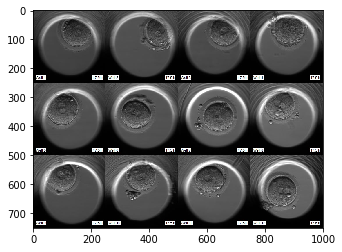

481
(750, 1000, 3)


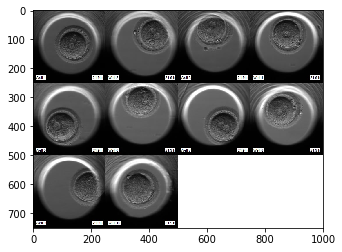

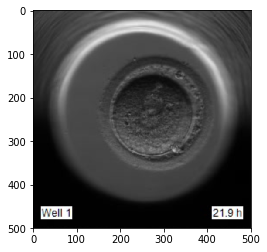

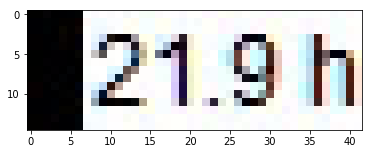

In [7]:
#sanity check

output_multi = 'Frames/Ukraine-multi_well'

video1 = os.listdir('./Videos/multi-well/')[0]

vidcap = cv2.VideoCapture('./Videos/multi-well/'+video1)
success,image = vidcap.read()
if success:
    length = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    print length
    print image.shape
    plt.imshow(image)
    plt.show()
    
video2 = os.listdir('./Videos/multi-well/')[1]

vidcap = cv2.VideoCapture('./Videos/multi-well/'+video2)
success,image = vidcap.read()
if success:
    length = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    print length
    print image.shape
    plt.imshow(image)
    plt.show()
    
vidcap = cv2.VideoCapture('./Videos/multi-well/'+video2)
success,image = vidcap.read()
if success:
    crop_img = image[0:250,0:250]
    crop_img = cv2.resize(crop_img, (500,500))
    
    plt.imshow(crop_img)
    plt.show()
    
vidcap = cv2.VideoCapture('./Videos/multi-well/'+video2)
success,image = vidcap.read()
if success:
    crop_img = image[0:250, 0:250]
    crop_img = extract_clock(crop_img, (250,250))
    
    plt.imshow(crop_img)
    plt.show()

In [ ]:
'''prefix = 'Files/Videos-exports/'
download_dir = 'Videos/'
    
prefix = 'Files/Videos-exports/'
download_dir = 'Videos/'
blobs = bucket.list_blobs(prefix = prefix, max_results = 1)
for i,blob in enumerate(blobs):
    if 'avi' in blob.name:
        filepath = blob.name.replace(prefix, download_dir)
        #download the file locally; where does NOT mean your computer but the location of your runtime environment
        print i, filepath
        blob.download_to_filename(filepath)
        
#sanity check
!ls {temp_file}'''

In [ ]:
digit_model = 'model_lenet_embryo.h5'
digit_weights = 'model_lenet_embryo_weights.h5'
height, width = 500, 500

input_multi = './Videos/multi-well/'
output_dir = './Frames/Ukraine-multi_well/'

wells_key = {(1,500,500) : ((1,1),(500,500)), (2, 500, 1000): ((1,2),(500,500)), (3,500,1500) : ((1,3),(500,500)), 
             (4, 500, 500): ((2,2),(250,250)), (5, 500, 750): ((2,3),(250,250)), (6,500,750) : ((2,3),(250,250)), \
             (7, 750, 750): ((3,3),(250,250)), (8,750,750) : ((3,3),(250,250)), (9,750,750) : ((3,3),(250,250)), \
             (10,750,1000) : ((3,4),(250,250)), (11, 750, 1000): ((3,4),(250,250)), (12,750,1000) : ((3,4),(250,250))}

digits_model_gcs = bucket.get_blob(model_dir + '/Digits/' + digit_model)
digits_weights_gcs = bucket.get_blob(model_dir + '/Digits/' + digit_weights)
digits_model_gcs.download_to_filename('/tmp/' + digit_model)
digits_weights_gcs.download_to_filename('/tmp/' + digit_weights)
model = load_model(digit_model)
model.load_weights(digit_weights)
    
IND = 2

#for video_name in os.listdir(input_multi)[0:IND]:
for video_name in os.listdir(input_multi):
    wells = map(int, video_name.split('wells_')[-1].split('_video.')[0].split('_'))
    n_wells = len(wells)
    vidcap = cv2.VideoCapture('./Videos/multi-well/' + video_name)
    length = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    success,image = vidcap.read()
    if success:
        count = 0
        length = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
        partition, dimensions = wells_key[(len(wells),image.shape[0],image.shape[1])]
        print video_name, length, image.shape
        print partition, dimensions        
    while success:
        #cv2 is height x width
        #window_size = np.sqrt((image.shape[0]*image.shape[1]) / n_wells)
        
        for i in range(partition[0]): #rows
            for j in range(partition[1]): #cols
                if (i*partition[1]+j) < len(wells):
                    #plt.subplot(partition[0], partition[1], i*partition[1]+j+1)
                    crop_img = image[(i*dimensions[0]):((i+1)*dimensions[0]), (j*dimensions[1]):((j+1)*dimensions[1])]
                    #plt.imshow(crop_img)
                    filename = video_name.split('wells_')[0]
                    well = wells[i*partition[1]+j]
                    base_dir = "{}/{}_well{}".format(output_dir, filename, well)
                    if not os.path.exists(base_dir):
                        os.makedirs(base_dir)
                    #cv2.imwrite(filename, crop_img)
                    image_number = extract_clock(crop_img, dimensions)
                    image_number_img = Image.fromarray(image_number)
                    image_number = np.asarray(image_number_img)
                    number = clock2number(image_number, model)
                    if number == 0.0:
                        img = Image.fromarray(image_number)
                        img.save("{}/{}_well{}_f{:03d}_{}h_number.jpg".format(base_dir, filename, well, count, number))
                    crop_img = cv2.resize(crop_img, (height,width))
                    img = Image.fromarray(crop_img)
                    img = img.crop((0, 0, 474, 447))
                    img = img.resize((height, width))
                    if not os.path.exists("{}/{}_well{}_f{:03d}_{}h.jpg".format(base_dir, filename, well, count, number)):
                        img.save("{}/{}_well{}_f{:03d}_{}h.jpg".format(base_dir, filename, well, count, number))
                    img.close()
                
        count +=1
        success,image = vidcap.read()
        
    #plt.figure(figsize = (15,15))
    #plt.show()

D2013.11.05_S0407_I162_wells_1_2_3_4_5_6_7_8_9_10_11_12_video.avi 385 (750, 1000, 3)
(3, 4) (250, 250)
D2013.08.24_S0341_I162_wells_1_2_3_4_5_6_7_8_9_10_video.avi 481 (750, 1000, 3)
(3, 4) (250, 250)
D2013.11.12_S0417_I162_wells_1_2_3_4_5_6_7_8_9_video.avi 386 (750, 750, 3)
(3, 3) (250, 250)
D2014.04.03_S0514_I162_wells_1_2_3_4_5_6_7_8_9_10_11_12_video.avi 408 (750, 1000, 3)
(3, 4) (250, 250)
D2013.05.16_S0274_I162_wells_1_2_3_4_5_6_7_8_video.avi 408 (750, 750, 3)
(3, 3) (250, 250)
D2012.06.30_S0075_I162_wells_1_2_3_4_5_6_7_8_9_10_11_12_video.avi 353 (750, 1000, 3)
(3, 4) (250, 250)
D2013.03.30_S0246_I162_wells_1_2_3_4_5_6_7_8_9_10_11_12_video.avi 372 (750, 1000, 3)
(3, 4) (250, 250)
D2013.02.22_S0209_I162_wells_1_2_3_4_5_6_7_8_9_10_11_12_video.avi 400 (750, 1000, 3)
(3, 4) (250, 250)
D2014.09.30_S0651_I162_wells_1_2_3_4_5_6_video.avi 388 (500, 750, 3)
(2, 3) (250, 250)
D2012.11.15_S0153_I162_wells_1_2_3_4_5_6_7_8_9_10_video.avi 373 (750, 1000, 3)
(3, 4) (250, 250)
D2015.09.13_S0898_I1

In [10]:
#mport multiprocessing
#mport itertools
#pool = multiprocessing.Pool(processes = 2)
#process_video_file_args = process_video_file(video_names, bucket = bucket, model_dir = model_dir, data_dir = video_dir, output_dir = './Frames/Ukraine-multi_well_new/')
#pool.map(process_video_file_args, itertools.izip(a_args, itertools.repeat(second_arg)))
#pool.close()
#pool.join()

video_dir = 'Files/Videos/Ukraine/Nadiya_part3/Nadiya_part3/2'

video_blobs = bucket.list_blobs(prefix = video_dir)
video_names = [blob.name for blob in video_blobs]

process_video_file(video_names, bucket = bucket, output_dir = './Frames/Ukraine-multi_well_new/')

#process_video_file(video_names, bucket, output_dir, temp_dir = '/tmp/', fault_dir = './Fault/', \
#                       height = 500, width = 500, overwrite_model = False, fault_save = True, \
#                       digit_model_name = 'Upload/Models/Digits/model_lenet_embryo.h5', digit_weights_name = 'Upload/Models/Digits/model_lenet_embryo_weights.h5')

/tmp/D2014.07.29_S0607_I162_wells_1_2_video.avi 387 (500, 1000, 3)
(1, 2) (500, 500)
/tmp/D2014.10.18_S0671_I162_wells_1_2_video.avi 480 (500, 1000, 3)
(1, 2) (500, 500)
/tmp/D2015.03.07_S0768_I162_wells_1_2_video.avi 381 (500, 1000, 3)
(1, 2) (500, 500)
/tmp/D2015.03.17_S0775_I162_wells_1_2_video.avi 579 (500, 1000, 3)
(1, 2) (500, 500)
/tmp/D2015.03.17_S0776_I162_wells_1_2_video.avi 405 (500, 1000, 3)
(1, 2) (500, 500)
/tmp/D2015.03.28_S0788_I162_wells_1_2_video.avi 376 (500, 1000, 3)
(1, 2) (500, 500)
/tmp/D2015.09.03_S0892_I162_wells_1_2_video.avi 394 (500, 1000, 3)
(1, 2) (500, 500)
/tmp/D2016.03.10_S1032_I162_wells_1_2_video.avi 394 (500, 1000, 3)
(1, 2) (500, 500)
/tmp/D2016.06.11_S1102_I162_wells_1_2_video.avi 377 (500, 1000, 3)
(1, 2) (500, 500)
/tmp/D2016.09.07_S1169_I162_wells_1_2_video.avi 472 (500, 1000, 3)
(1, 2) (500, 500)
/tmp/D2016.10.27_S1212_I162_wells_1_2_video.avi 402 (500, 1000, 3)
(1, 2) (500, 500)
/tmp/D2017.08.11_S01461_I0162_D_wells_1_2_video.avi 469 (500, 100

In [11]:
video_dir = 'Files/Videos/Ukraine/Nadiya_part3/Nadiya_part3/3'

video_blobs = bucket.list_blobs(prefix = video_dir)
video_names = [blob.name for blob in video_blobs]

process_video_file(video_names, bucket = bucket, output_dir = './Frames/Ukraine-multi_well_new/')

/tmp/D2014.03.01_S0494_I162_wells_1_2_3_video.avi 381 (500, 1500, 3)
(1, 3) (500, 500)
/tmp/D2014.04.18_S0530_I162_wells_1_2_3_video.avi 574 (500, 1500, 3)
(1, 3) (500, 500)
/tmp/D2014.05.29_S0562_I162_wells_1_2_3_video.avi 574 (500, 1500, 3)
(1, 3) (500, 500)
/tmp/D2014.06.05_S0566_I162_wells_1_2_3_video.avi 485 (500, 1500, 3)
(1, 3) (500, 500)
/tmp/D2014.10.11_S0661_I162_wells_1_2_3_video.avi 380 (500, 1500, 3)
(1, 3) (500, 500)
/tmp/D2014.10.13_S0665_I162_wells_9_10_12_video.avi 445 (500, 1500, 3)
(1, 3) (500, 500)
/tmp/D2014.11.06_S0684_I162_wells_1_2_3_video.avi 569 (500, 1500, 3)
(1, 3) (500, 500)
/tmp/D2014.11.15_S0686_I162_wells_1_2_3_video.avi 474 (500, 1500, 3)
(1, 3) (500, 500)
/tmp/D2014.11.20_S0693_I162_wells_1_2_3_video.avi 473 (500, 1500, 3)
(1, 3) (500, 500)
/tmp/D2014.11.27_S0698_I162_wells_1_2_3_video.avi 574 (500, 1500, 3)
(1, 3) (500, 500)
/tmp/D2014.12.17_S0716_I162_wells_1_2_3_video.avi 385 (500, 1500, 3)
(1, 3) (500, 500)
/tmp/D2014.12.30_S0728_I162_wells_1_2_3_v

In [12]:
video_dir = 'Files/Videos/Ukraine/Nadiya_part3/Nadiya_part3/4'

video_blobs = bucket.list_blobs(prefix = video_dir)
video_names = [blob.name for blob in video_blobs]

process_video_file(video_names, bucket = bucket, output_dir = './Frames/Ukraine-multi_well_new/')

/tmp/D2014.06.20_S0580_I162_wells_1_2_3_4_video.avi 386 (500, 500, 3)
(2, 2) (250, 250)
/tmp/D2014.09.13_S0641_I162_wells_1_2_3_4_video.avi 504 (500, 500, 3)
(2, 2) (250, 250)
/tmp/D2014.09.18_S0644_I162_wells_1_2_3_4_video.avi 398 (500, 500, 3)
(2, 2) (250, 250)
/tmp/D2014.09.25_S0649_I162_wells_1_2_3_4_video.avi 572 (500, 500, 3)
(2, 2) (250, 250)
/tmp/D2014.10.14_S0667_I162_wells_1_2_3_4_video.avi 391 (500, 500, 3)
(2, 2) (250, 250)
/tmp/D2014.11.14_S0685_I162_wells_2_3_4_5_video.avi 487 (500, 500, 3)
(2, 2) (250, 250)
/tmp/D2014.11.15_S0688_I162_wells_1_2_3_4_video.avi 380 (500, 500, 3)
(2, 2) (250, 250)
/tmp/D2014.11.27_S0699_I162_wells_1_2_3_4_video.avi 480 (500, 500, 3)
(2, 2) (250, 250)
/tmp/D2014.11.29_S0703_I162_wells_1_2_3_7_video.avi 473 (500, 500, 3)
(2, 2) (250, 250)
/tmp/D2015.01.09_S0733_I162_wells_1_2_3_4_video.avi 476 (500, 500, 3)
(2, 2) (250, 250)
/tmp/D2015.01.15_S0736_I162_wells_2_3_4_5_video.avi 481 (500, 500, 3)
(2, 2) (250, 250)
/tmp/D2015.02.12_S0749_I162_well

In [13]:
video_dir = 'Files/Videos/Ukraine/Nadiya_part3/Nadiya_part3/5'

video_blobs = bucket.list_blobs(prefix = video_dir)
video_names = [blob.name for blob in video_blobs]

process_video_file(video_names, bucket = bucket, output_dir = './Frames/Ukraine-multi_well_new/')

/tmp/D2014.03.27_S0508_I162_wells_1_2_3_4_5_video.avi 477 (500, 750, 3)
(2, 3) (250, 250)
/tmp/D2014.05.04_S0542_I162_wells_1_2_3_4_5_video.avi 394 (500, 750, 3)
(2, 3) (250, 250)
/tmp/D2014.05.31_S0564_I162_wells_1_2_3_4_5_video.avi 375 (500, 750, 3)
(2, 3) (250, 250)
/tmp/D2014.08.06_S0613_I162_wells_1_2_3_4_6_video.avi 459 (500, 750, 3)
(2, 3) (250, 250)
/tmp/D2014.09.25_S0647_I162_wells_1_2_3_4_7_video.avi 572 (500, 750, 3)
(2, 3) (250, 250)
/tmp/D2014.12.25_S0722_I162_wells_1_2_3_4_5_video.avi 384 (500, 750, 3)
(2, 3) (250, 250)
/tmp/D2015.01.30_S0741_I162_wells_1_2_3_4_5_video.avi 490 (500, 750, 3)
(2, 3) (250, 250)
/tmp/D2015.02.28_S0760_I162_wells_1_2_3_4_5_video.avi 472 (500, 750, 3)
(2, 3) (250, 250)
/tmp/D2015.03.15_S0773_I162_wells_1_2_3_4_5_video.avi 487 (500, 750, 3)
(2, 3) (250, 250)
/tmp/D2015.04.02_S0793_I162_wells_1_2_3_4_5_video.avi 477 (500, 750, 3)
(2, 3) (250, 250)
/tmp/D2015.07.09_S0867_I162_wells_1_2_3_4_5_video.avi 396 (500, 750, 3)
(2, 3) (250, 250)
/tmp/D2015

In [ ]:
video_dir = 'Files/Videos/Ukraine/Nadiya_part3/Nadiya_part3/6'

video_blobs = bucket.list_blobs(prefix = video_dir)
video_names = [blob.name for blob in video_blobs]

process_video_file(video_names, bucket = bucket, output_dir = './Frames/Ukraine-multi_well_new/')

In [14]:
video_dir = 'Files/Videos/Ukraine/Nadiya_part3/Nadiya_part3/7'

video_blobs = bucket.list_blobs(prefix = video_dir)
video_names = [blob.name for blob in video_blobs]

process_video_file(video_names, bucket = bucket, output_dir = './Frames/Ukraine-multi_well_new/')

/tmp/D2014.05.22_S0553_I162_wells_1_2_3_4_5_7_8_video.avi 479 (750, 750, 3)
(3, 3) (250, 250)
/tmp/D2014.06.13_S0573_I162_wells_1_2_3_4_5_6_7_video.avi 480 (750, 750, 3)
(3, 3) (250, 250)
/tmp/D2014.09.06_S0636_I162_wells_1_2_5_6_7_8_9_video.avi 557 (750, 750, 3)
(3, 3) (250, 250)
/tmp/D2014.09.13_S0639_I162_wells_1_2_3_4_5_6_7_video.avi 572 (750, 750, 3)
(3, 3) (250, 250)
/tmp/D2014.10.05_S0658_I162_wells_1_2_3_4_5_6_7_video.avi 466 (750, 750, 3)
(3, 3) (250, 250)
/tmp/D2014.10.12_S0662_I162_wells_1_2_3_4_5_6_7_video.avi 397 (750, 750, 3)
(3, 3) (250, 250)
/tmp/D2014.10.16_S0668_I162_wells_1_2_3_4_5_6_7_video.avi 393 (750, 750, 3)
(3, 3) (250, 250)
/tmp/D2014.10.28_S0678_I162_wells_1_2_3_4_5_6_7_video.avi 583 (750, 750, 3)
(3, 3) (250, 250)
/tmp/D2014.12.14_S0712_I162_wells_1_2_3_4_5_6_7_video.avi 387 (750, 750, 3)
(3, 3) (250, 250)
/tmp/D2015.01.09_S0734_I162_wells_1_2_3_4_5_6_7_video.avi 474 (750, 750, 3)
(3, 3) (250, 250)
/tmp/D2015.01.29_S0739_I162_wells_1_2_3_4_5_6_7_video.avi 49

In [15]:
video_dir = 'Files/Videos/Ukraine/Nadiya_part3/Nadiya_part3/8'

video_blobs = bucket.list_blobs(prefix = video_dir)
video_names = [blob.name for blob in video_blobs]

process_video_file(video_names, bucket = bucket, output_dir = './Frames/Ukraine-multi_well_new/')

/tmp/D2014.04.03_S0513_I162_wells_1_2_3_4_5_6_7_8_video.avi 402 (750, 750, 3)
(3, 3) (250, 250)
/tmp/D2014.04.24_S0533_I162_wells_1_2_3_4_5_6_7_9_video.avi 476 (750, 750, 3)
(3, 3) (250, 250)
/tmp/D2014.08.30_S0631_I162_wells_1_2_3_4_5_6_8_9_video.avi 384 (750, 750, 3)
(3, 3) (250, 250)
/tmp/D2014.09.11_S0637_I162_wells_1_2_3_4_5_6_7_8_video.avi 480 (750, 750, 3)
(3, 3) (250, 250)
/tmp/D2014.11.18_S0690_I162_wells_1_2_3_4_5_6_7_8_video.avi 485 (750, 750, 3)
(3, 3) (250, 250)
/tmp/D2015.03.12_S0770_I162_wells_1_2_3_4_5_6_7_8_video.avi 478 (750, 750, 3)
(3, 3) (250, 250)
/tmp/D2015.06.05_S0842_I162_wells_3_4_5_6_7_8_10_11_video.avi 555 (750, 750, 3)
(3, 3) (250, 250)
/tmp/D2015.06.23_S0853_I162_wells_1_2_3_4_5_6_7_8_video.avi 394 (750, 750, 3)
(3, 3) (250, 250)
/tmp/D2015.08.07_S0878_I162_wells_1_2_3_4_5_6_7_8_video.avi 392 (750, 750, 3)
(3, 3) (250, 250)
/tmp/D2015.08.11_S0884_I162_wells_1_2_3_4_5_6_7_8_video.avi 566 (750, 750, 3)
(3, 3) (250, 250)
/tmp/D2015.10.14_S0913_I162_wells_1_2_